In [1]:
pip install gitpython

In [2]:
import git
import os

# URL of the GitHub repository
repo_url = "https://github.com/manuelamc14/waste-classification-model.git"

# Directory where you want to clone the repository
target_directory = "waste-classification-model"

# Clone the repository
if not os.path.exists(target_directory):
    git.Repo.clone_from(repo_url, target_directory)
    print("Repository cloned successfully!")
else:
    print("Repository already exists!")

Repository already exists!


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define data directories
base_dir = 'waste-classification-model/Resources/Dataset'
train_dir = 'waste-classification-model/Resources/Dataset/Train'
test_dir = 'waste-classification-model/Resources/Dataset/Test'

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    #horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Batch size
batch_size = 32

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

# Pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(2, activation='softmax')(x)

# Final model
model3 = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze the first few layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Compile model
model3.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3)

# Training
history = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=8,  # Reduced number of epochs to 8
    callbacks=[early_stopping, reduce_lr]
)

# Evaluation
model3.evaluate(test_generator)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.
94765736/94765736 [==============================] - 0s 0us/step


Epoch 1/8
705/705 [==============================] - 180s 239ms/step - loss: 0.5682 - accuracy: 0.7172 - val_loss: 0.7731 - val_accuracy: 0.5581 - lr: 0.0010
Epoch 2/8
705/705 [==============================] - 157s 223ms/step - loss: 0.5138 - accuracy: 0.7541 - val_loss: 0.5111 - val_accuracy: 0.7476 - lr: 0.0010
Epoch 3/8
705/705 [==============================] - 158s 224ms/step - loss: 0.4980 - accuracy: 0.7681 - val_loss: 0.5006 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 4/8
705/705 [==============================] - 159s 225ms/step - loss: 0.4957 - accuracy: 0.7668 - val_loss: 1.4789 - val_accuracy: 0.4679 - lr: 0.0010
Epoch 5/8
705/705 [==============================] - 157s 223ms/step - loss: 0.4892 - accuracy: 0.7747 - val_loss: 0.7673 - val_accuracy: 0.6554 - lr: 0.0010
Epoch 6/8
705/705 [==============================] - 160s 226ms/step - loss: 0.4800 - accuracy: 0.7747 - val_loss: 0.4899 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 7/8
705/705 [==============================] -

[0.5152774453163147, 0.7755670547485352]

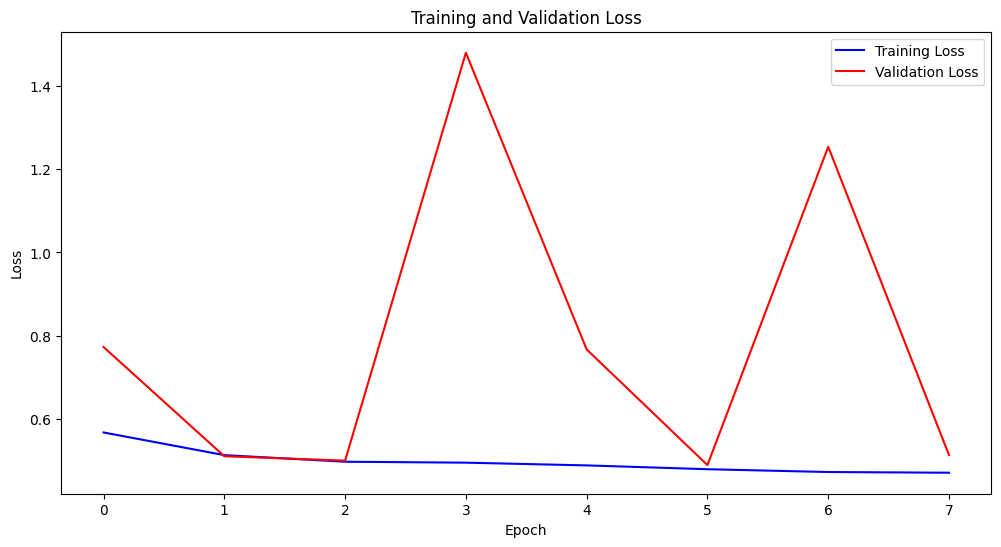

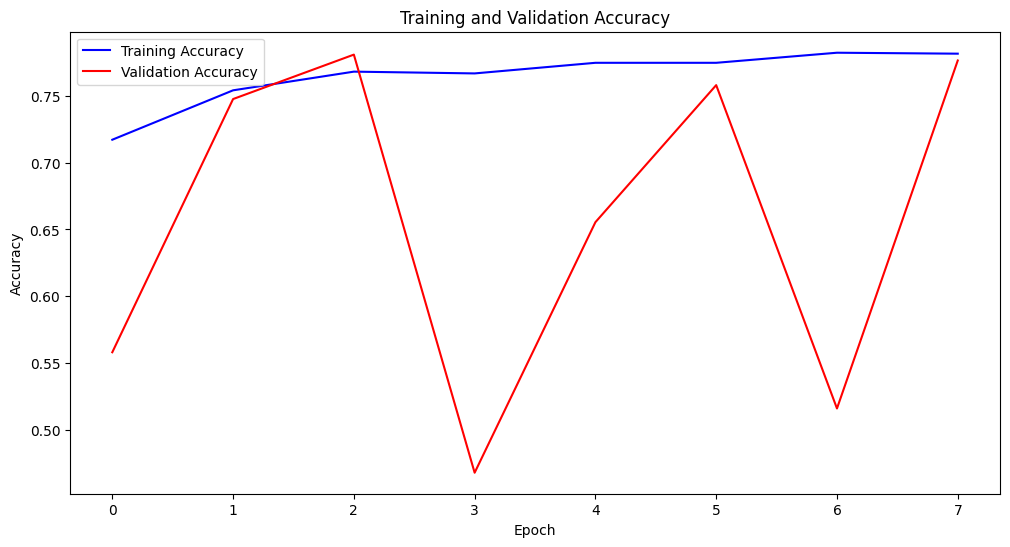

In [5]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


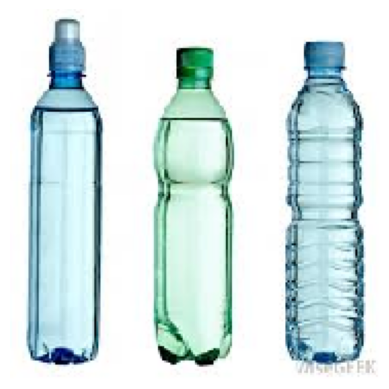

1/1 [==============================] - 0s 25ms/step
Predicted class: Recyclable Waste


In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load an image for testing
img_path = '/content/R_1005 (1).jpg'  # Replace 'path_to_your_image.jpg' with the path to your image
img = image.load_img(img_path, target_size=(180, 180))  # Ensure that target_size matches the input shape of the model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Make predictions
predictions = model3.predict(img_array)

# Convert predictions to class labels
class_labels = ['Organic Waste', 'Recyclable Waste']
predicted_class = class_labels[np.argmax(predictions)]

# Print the predicted class
print("Predicted class:", predicted_class)


In [10]:
 model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [12]:
# Evaluate model on test data
loss, accuracy = model3.evaluate(test_generator)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


79/79 [==============================] - 5s 66ms/step - loss: 0.5153 - accuracy: 0.7756
Test Loss: 0.5152773857116699
Test Accuracy: 0.7755670547485352


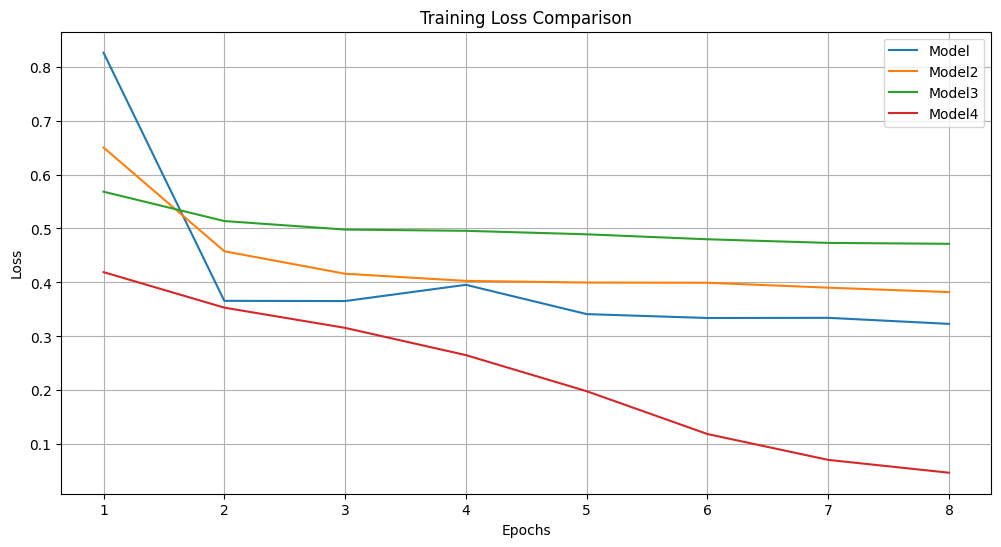

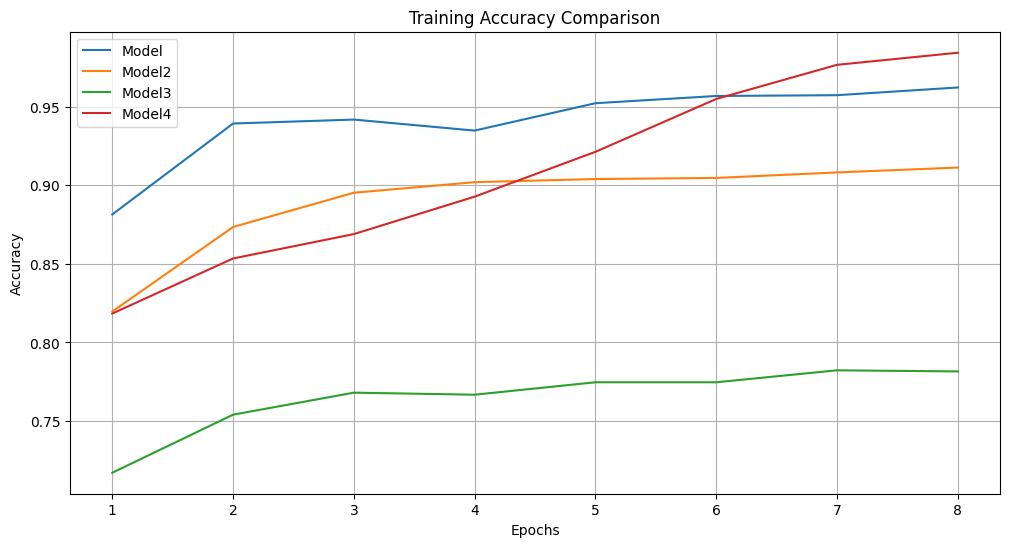

In [13]:
#comparison between the models

import matplotlib.pyplot as plt

# Loss and Accuracy Data for all Models
loss_data = {
    "Model": [0.8258, 0.3659, 0.3655, 0.3956, 0.3413, 0.3341, 0.3344, 0.3232],
    "Model2": [0.6501, 0.4578, 0.4161, 0.4029, 0.3998, 0.3994, 0.3903, 0.3821],
    "Model3": [0.5682, 0.5138, 0.4980, 0.4957, 0.4892, 0.4800, 0.4733, 0.4716],
    "Model4": [0.4191, 0.3533, 0.3158, 0.2653, 0.1984, 0.1190, 0.0711, 0.0473]
}

accuracy_data = {
    "Model": [0.8814, 0.9392, 0.9417, 0.9347, 0.9521, 0.9567, 0.9572, 0.9621],
    "Model2": [0.8197, 0.8734, 0.8952, 0.9019, 0.9039, 0.9046, 0.9081, 0.9112],
    "Model3": [0.7172, 0.7541, 0.7681, 0.7668, 0.7747, 0.7747, 0.7823, 0.7816],
    "Model4": [0.8184, 0.8534, 0.8689, 0.8927, 0.9212, 0.9548, 0.9765, 0.9842]
}

epochs = range(1, len(loss_data["Model"]) + 1)

# Plotting Loss
plt.figure(figsize=(12, 6))
for model, loss in loss_data.items():
    plt.plot(epochs, loss, label=model)

plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Accuracy
plt.figure(figsize=(12, 6))
for model, accuracy in accuracy_data.items():
    plt.plot(epochs, accuracy, label=model)

plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import pandas as pd

# Define data
data = {
    'Model': ['Model', 'Model2', 'Model3', 'Model4'],
    'Final Loss': [0.8258, 0.3659, 0.3232, 0.0473],
    'Final Accuracy': [0.8814, 0.9392, 0.9621, 0.9842],
    'Training Time (s)': [282, 5640, 180, 380]
}

# Create DataFrame
df = pd.DataFrame(data)

# Print DataFrame
print(df)


    Model  Final Loss  Final Accuracy  Training Time (s)
0   Model      0.8258          0.8814                282
1  Model2      0.3659          0.9392               5640
2  Model3      0.3232          0.9621                180
3  Model4      0.0473          0.9842                380


In [15]:
import pandas as pd

# Define data
data = {
    'Model': ['Model', 'Model2', 'Model3', 'Model4'],
    'Final Loss': [0.8258, 0.3659, 0.3232, 0.0473],
    'Final Accuracy': [0.8814, 0.9392, 0.9621, 0.9842],
    'Training Time (s)': [282, 5640, 180, 380]
}

# Create DataFrame
df = pd.DataFrame(data)

# Rank models based on final accuracy
df['Rank'] = df['Final Accuracy'].rank(ascending=False)

# Sort DataFrame by rank
df = df.sort_values(by='Rank')

# Set index to rank
df.set_index('Rank', inplace=True)

# Print DataFrame
print(df)


       Model  Final Loss  Final Accuracy  Training Time (s)
Rank                                                       
1.0   Model4      0.0473          0.9842                380
2.0   Model3      0.3232          0.9621                180
3.0   Model2      0.3659          0.9392               5640
4.0    Model      0.8258          0.8814                282
